# Consumer Compaints Data
# Predict Related Product Probability using NLP techniques and Naive Bayes (For Multi Class Classification)

#### Checking Python Version and Path

In [1]:
import sys
print(sys.version)
print(sys.path)

3.10.12 (main, Jul  5 2023, 15:34:07) [Clang 14.0.6 ]
['/Users/vatsal/SSDCopy/Projects/NLP-ConsumerComplaintReviewProbabilityPredictionNaiveBayes/notebooks', '/Users/vatsal/SSDCopy/Projects', '/Users/vatsal/miniconda/envs/Python310/lib/python310.zip', '/Users/vatsal/miniconda/envs/Python310/lib/python3.10', '/Users/vatsal/miniconda/envs/Python310/lib/python3.10/lib-dynload', '', '/Users/vatsal/miniconda/envs/Python310/lib/python3.10/site-packages']


#### Importing Required Packages to read data and perform some EDA

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
%matplotlib inline

In [9]:
pd.set_option('display.max_colwidth', 20)

##### Reading the Input Data

In [3]:
consumer_complaints = pd.read_csv('../data/complaints.csv')

In [10]:
consumer_complaints.shape

(2326246, 18)

#### About 2.3 Million Rows and 18 Columns

In [11]:
consumer_complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,Credit reporting...,Credit reporting,Incorrect inform...,Information belo...,NaN,NaN,CAPITAL ONE FINA...,PA,186XX,NaN,Consent not prov...,Web,2019-06-13,Closed with expl...,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or ...,Loan,Struggling to pa...,Denied request t...,I contacted Ally...,Company has resp...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with expl...,Yes,NaN,3425257
2,2019-04-01,Credit reporting...,Credit reporting,Incorrect inform...,Account status i...,NaN,Company has resp...,TRANSUNION INTER...,PA,19067,NaN,Consent not prov...,Web,2019-04-01,Closed with expl...,Yes,NaN,3198225
3,2021-11-01,Credit reporting...,Credit reporting,Problem with a c...,Was not notified...,NaN,NaN,TRANSUNION INTER...,GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threaten...,Threatened or su...,NaN,NaN,Medical Data Sys...,VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


#### For learning purposes, focusing only on Consumer Complaint Narrative and the Product Column

In [12]:
pd.set_option('display.max_colwidth', 999)

In [13]:
consumer_complaints['Consumer complaint narrative'][~(consumer_complaints['Consumer complaint narrative'].isna())].head()

1     I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work for a short period of time due to an illness. I chated with a representative after logging into my account regarding my opitions to ensure I protect my credit and bring my account current. \n\nShe advised me that before an extenstion could be done, I had to make a payment in the amount of {$270.00}. I reviewed my finances, as I am playing catch up on all my bills and made this payment on Monday XX/XX/XXXX. This rep advised me, once this payment posts to my account to contact Ally back for an extention or to have a payment deffered to the end of my loan. \n\nWith this in mind, I contacted Ally again today and chatted with XXXX. I explained all of the above and the information I was provided when I chatted with the rep last week. She asked several questions and advised me that a one or two month  extension/deffered payment could be done however partial payment is needed! WHAT? She advise

##### I get a sense of the consumer complaint data. Now I will take a look at the related products

In [17]:
consumer_complaints['Product'][~(consumer_complaints['Consumer complaint narrative'].isna())].head()

1                                                            Vehicle loan or lease
7     Credit reporting, credit repair services, or other personal consumer reports
8     Credit reporting, credit repair services, or other personal consumer reports
10    Credit reporting, credit repair services, or other personal consumer reports
13    Credit reporting, credit repair services, or other personal consumer reports
Name: Product, dtype: object

In [18]:
pd.set_option('display.max_colwidth', 100)

##### Let's look at the spread of data across different consumer complaints

In [20]:
consumer_complaints["Product"].value_counts(normalize=True)*100

Product
Credit reporting, credit repair services, or other personal consumer reports    37.035034
Debt collection                                                                 16.683876
Mortgage                                                                        14.614319
Credit reporting                                                                 6.036808
Credit card or prepaid card                                                      5.366156
Checking or savings account                                                      4.451292
Credit card                                                                      3.834074
Bank account or service                                                          3.705799
Student loan                                                                     2.732342
Money transfer, virtual currency, or money service                               1.453415
Consumer Loan                                                                    1.358412
Ve

##### Data is mostly about Credit Reporting, Data Collection, Mortgage, Credit/Debit Cards and Checking/Savings Accounts. These Products total to about 91% of the data.

In [43]:
consumer_complaints["Consumer complaint narrative"].isnull().sum(), consumer_complaints["Consumer complaint narrative"].isna().sum()

(1516903, 1516903)

##### About 1.5 million Complaints have no narrative.
##### Lets look at the complaint spread for the Product columns where the data is not null or na

In [23]:
consumer_complaints[~(consumer_complaints["Consumer complaint narrative"].isnull())]["Product"].value_counts(normalize=True)*100

Product
Credit reporting, credit repair services, or other personal consumer reports    39.101469
Debt collection                                                                 19.445526
Mortgage                                                                        10.435749
Credit card or prepaid card                                                      7.506582
Checking or savings account                                                      4.619673
Credit reporting                                                                 3.902919
Student loan                                                                     3.594768
Credit card                                                                      2.327567
Money transfer, virtual currency, or money service                               2.296060
Vehicle loan or lease                                                            1.857556
Bank account or service                                                          1.839146
Pa

In [24]:
39.101 + 19.44 + 10.435 + 7.506 + 4.619 + 3.902 + 3.594

88.597

##### Top 7 Product Categories contribute about 89% of complaints. Student Loans which represented about 2.73% of data before null cleanup has jumped up to 3.594%

#### Keeping only 2 columns of Interest and dropping the records with missing Complaints data (Null)

In [25]:
complaints_data = consumer_complaints[['Consumer complaint narrative', 'Product']]

In [26]:
complaints_data.columns = ["Complaints", "Product"]

In [27]:
complaints_data.columns

Index(['Complaints', 'Product'], dtype='object')

In [30]:
complaints_data.dropna(inplace=True)
complaints_data.shape

/var/folders/y2/ff1bp6sj4hq36hkps05494740000gn/T/ipykernel_9719/2444864910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_data.dropna(inplace=True)


(809343, 2)

##### Lets look at the unique Products

In [28]:
complaints_data.Product.nunique(),complaints_data.Product.unique()

(18,
 array(['Credit reporting, credit repair services, or other personal consumer reports',
        'Vehicle loan or lease', 'Debt collection', 'Mortgage',
        'Credit card or prepaid card', 'Checking or savings account',
        'Money transfer, virtual currency, or money service',
        'Student loan', 'Payday loan, title loan, or personal loan',
        'Consumer Loan', 'Bank account or service', 'Money transfers',
        'Credit reporting', 'Credit card', 'Other financial service',
        'Payday loan', 'Prepaid card', 'Virtual currency'], dtype=object))

#### Mapping these to simpler categories

In [35]:
ProductMapping = 
{'Credit reporting, credit repair services, or other personal consumer reports': "Credit_Report",
'Vehicle loan or lease' : "Auto_Loan",
'Debt collection' : "Collections",
'Mortgage' : "Mortgage",
'Credit card or prepaid card' : "Card",
'Checking or savings account' : "Bank_Account",
'Money transfer, virtual currency, or money service': "Money_Transfer",
'Student loan' : "Loan",
'Payday loan, title loan, or personal loan' : "Loan",
'Consumer Loan' : "Loan",
'Bank account or service' : "Bank_Account",
'Money transfers' : "Money_Transfer",
'Credit reporting': "Credit_Report",
'Credit card' : "Card",
'Other financial service' : "Others",
'Payday loan' : "Loan",
'Prepaid card' : "Card",
'Virtual currency' : "Money_Transfer"}

In [38]:
complaints_data["Product"] = complaints_data["Product"].map(ProductMapping)

/var/folders/y2/ff1bp6sj4hq36hkps05494740000gn/T/ipykernel_9719/2259159054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_data["Product"] = complaints_data["Product"].map(ProductMapping)


In [39]:
complaints_data.Product.nunique(),complaints_data.Product.unique()

(9,
 array(['Auto_Loan', 'Credit_Report', 'Card', 'Money_Transfer', 'Mortgage',
        'Loan', 'Collections', 'Bank_Account', 'Others'], dtype=object))

##### So now we have simplified the Products and are left with 9 Products

<Figure size 1400x800 with 0 Axes>

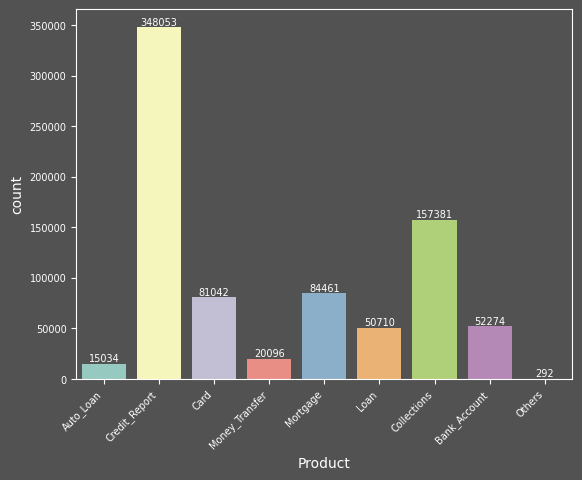

In [44]:
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots()
ax.set_facecolor("#525252")
fig.set_facecolor("#525252")
res = sns.countplot(x="Product", data=complaints_data
)
res.set_xticklabels(
    res.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=7, color='white')
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
plt.show()

In [45]:
complaints_data["Complaints"].shape

(809343,)

##### Will now perform some Text Pre Processing to prep the Complaint Narratives to be analysed for NLP

##### Importing nltk libraries

In [55]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from tqdm import tqdm

##### Converting the Complaints column to lower case

In [59]:
complaints_df = complaints_data["Complaints"].str.lower()

##### Tokekizing

In [62]:
complaints_df = complaints_df.map(word_tokenize)

In [65]:
print(complaints_df.iloc[13])

['my', 'credit', 'reports', 'list', 'monies', 'owed', 'to', 'xxxx', '.', 'i', 'have', 'written', 'to', 'the', 'collection', 'agency', ',', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'that', 'i', 'owe', 'monies', 'on', 'this', 'account', ',', 'but', 'none', 'was', 'ever', 'sent', '.', 'i', 'notified', 'the', 'credit', 'agencies', 'that', 'this', 'creditor', 'never', 'sent', 'me', 'the', 'required', 'proof', ',', 'yet', 'they', 'continue', 'to', 'list', 'this', 'account', 'on', 'my', 'credit', 'report', '.', 'my', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'and', 'xxxx', 'for', 'monies', 'owed', 'to', 'xxxx', '.', 'i', 'submitted', 'documentation', 'that', 'showed', 'that', 'the', 'original', 'creditor', 'was', 'paid', 'however', ',', 'the', 'credit', 'reporting', 'agencies', 'continue', 'to', 'list', 'xxxx', 'xxxx', 'on', 'my', 'credit', 'report', '.', 'furthermore', ',', 'two', 'separate', 'collection', 'agencies', 'can', 'not', 'be', 'listed', 'on', 'my', 'creditreport',

##### Removing Stop words

In [66]:
sw = stopwords.words('english')

In [72]:
def remove_stop_words(words):
    return [word for word in words if word not in sw]

In [73]:
complaints_df = complaints_df.apply(remove_stop_words)
print(complaints_df.iloc[13])

['credit', 'reports', 'list', 'monies', 'owed', 'xxxx', '.', 'written', 'collection', 'agency', ',', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'owe', 'monies', 'account', ',', 'none', 'ever', 'sent', '.', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', ',', 'yet', 'continue', 'list', 'account', 'credit', 'report', '.', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'monies', 'owed', 'xxxx', '.', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', ',', 'credit', 'reporting', 'agencies', 'continue', 'list', 'xxxx', 'xxxx', 'credit', 'report', '.', 'furthermore', ',', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', '.', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired', '.']


##### Remove Punctuations

In [74]:
tokenizer = RegexpTokenizer(r'\w+')

In [110]:
complaints_df = complaints_df.apply(lambda x: [" ".join(tokenizer.tokenize(t)) for t in x if len(tokenizer.tokenize(t))>0 ])

In [111]:
print(complaints_df.iloc[13])

['credit', 'reports', 'list', 'monies', 'owed', 'xxxx', 'written', 'collection', 'agency', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'owe', 'monies', 'account', 'none', 'ever', 'sent', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', 'yet', 'continue', 'list', 'account', 'credit', 'report', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'monies', 'owed', 'xxxx', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', 'credit', 'reporting', 'agencies', 'continue', 'list', 'xxxx', 'xxxx', 'credit', 'report', 'furthermore', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired']


##### Removing words such as xx, xxxx, xxxxx and numbers of the format 00, 000, 0000 using Regex

In [122]:
complaints_df = complaints_df.apply(lambda x: [(re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip()) for t in x if len((re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip())) > 0])

In [123]:
print(complaints_df.iloc[13])

['credit', 'reports', 'list', 'monies', 'owed', 'written', 'collection', 'agency', 'requesting', 'proof', 'owe', 'monies', 'account', 'none', 'ever', 'sent', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', 'yet', 'continue', 'list', 'account', 'credit', 'report', 'credit', 'reports', 'list', 'monies', 'owed', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', 'credit', 'reporting', 'agencies', 'continue', 'list', 'credit', 'report', 'furthermore', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired']


##### Performing Stemming

In [124]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [127]:
complaints_df = complaints_df.apply(lambda words: [stemmer.stem(word) for word in words])

In [128]:
print(complaints_df.iloc[13])

['credit', 'report', 'list', 'moni', 'owe', 'written', 'collect', 'agenc', 'request', 'proof', 'owe', 'moni', 'account', 'none', 'ever', 'sent', 'notifi', 'credit', 'agenc', 'creditor', 'never', 'sent', 'requir', 'proof', 'yet', 'continu', 'list', 'account', 'credit', 'report', 'credit', 'report', 'list', 'moni', 'owe', 'submit', 'document', 'show', 'origin', 'creditor', 'paid', 'howev', 'credit', 'report', 'agenc', 'continu', 'list', 'credit', 'report', 'furthermor', 'two', 'separ', 'collect', 'agenc', 'list', 'creditreport', 'account', 'credit', 'report', 'list', 'bankruptci', 'delet', 'sinc', '7', 'year', 'report', 'expir']


In [129]:
complaints_data.columns

Index(['Complaints', 'Product'], dtype='object')

##### Concatenating the cleaned/preprocessed complaints to the complaints_data dataframe

In [130]:
complaints_data["clean_complaints"] = complaints_df

/var/folders/y2/ff1bp6sj4hq36hkps05494740000gn/T/ipykernel_9719/3033562191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_data["clean_complaints"] = complaints_df


In [131]:
complaints_data.head()

,Complaints,Product,clean_complaints
1,I contacted Ally on Friday XX/XX/XXXX after falling behind on payments due to being out of work ...,Auto_Loan,"[contact, alli, friday, fall, behind, payment, due, work, short, period, time, due, ill, chate, ..."
7,"Hello This complaint is against the three credit reporting companies. XXXX, Trans Union and XXXX...",Credit_Report,"[hello, complaint, three, credit, report, compani, tran, union, notic, discrep, credit, report, ..."
8,I am a victim of Identity Theft & currently have an Experian account that I can view my Experian...,Credit_Report,"[victim, ident, theft, current, experian, account, view, experian, credit, report, get, notifi, ..."
10,Two accounts are still on my credit history after contacting the credit bureau. They have the in...,Credit_Report,"[two, account, still, credit, histori, contact, credit, bureau, incorrect, statu, account, balanc]"
13,Receiving daily telephone call ( s ) from XXXX XXXX XXXX identifying themselves as from an attor...,Credit_Report,"[receiv, daili, telephon, call, identifi, attorney, s, offic, unabl, decif, name, ask, 3, time, ..."


### Preparing Data for creating model

In [133]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

##### Initializing a Count Vectorizer

In [134]:
vect = CountVectorizer(min_df=200)

##### Joining the list of processed tokens back to sentence

In [136]:
complaints_data["clean_complaints"] = complaints_data["clean_complaints"].apply(lambda x: " ".join(x))

/var/folders/y2/ff1bp6sj4hq36hkps05494740000gn/T/ipykernel_9719/1116140422.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_data["clean_complaints"] = complaints_data["clean_complaints"].apply(lambda x: " ".join(x))


In [137]:
complaints_data["clean_complaints"].head()

1     contact alli friday fall behind payment due work short period time due ill chate repres log acco...
7     hello complaint three credit report compani tran union notic discrep credit report put credit fr...
8     victim ident theft current experian account view experian credit report get notifi activ experia...
10                  two account still credit histori contact credit bureau incorrect statu account balanc
13    receiv daili telephon call identifi attorney s offic unabl decif name ask 3 time ask confirm nam...
Name: clean_complaints, dtype: object

##### Fitting Vector Transform

In [138]:
X = vect.fit_transform(complaints_data["clean_complaints"])

In [139]:
X.shape

(809343, 5539)

In [140]:
y = complaints_data["Product"]

#### Splitting data in to train and test

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [142]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(647474, 5539) (647474,) (161869, 5539) (161869,)


#### Model Training using Naive Bayes

In [144]:
nb_model = MultinomialNB()

In [145]:
nb_model.fit(X_train, y_train)

MultinomialNB()

##### Predicting

In [146]:
test_pred = nb_model.predict(X_test)

In [147]:
accuracy_score(y_test, test_pred)

0.7833865656796546

###### Accuracy is around 78.3%

##### Visualize Confusion Matrix

In [148]:
conf_mat = confusion_matrix(y_test, test_pred)

In [149]:
conf_mat

array([[ 2127,    46,    52,   105,   322,   307,     8,    39,     1],
       [   48,  8174,   780,    93,   205,    78,   899,   159,    19],
       [  175,  1267, 12161,   407,  1208,   379,   520,    78,    14],
       [  608,   325,  1067, 22171,  5031,  1521,   149,   559,    45],
       [ 1877,   398,  3014,  4667, 56638,  1630,   162,  1148,    77],
       [ 1131,   225,   299,   631,   571,  6952,    87,   217,    29],
       [    8,   521,   146,    25,    26,    46,  3187,    40,    20],
       [  110,   215,   142,   196,   362,   383,    80, 15387,    17],
       [    0,    19,     6,     2,     1,     9,     8,     4,     9]])

In [151]:
conf_mat = pd.DataFrame(conf_mat, columns=nb_model.classes_, index=nb_model.classes_)

In [152]:
conf_mat

,Auto_Loan,Bank_Account,Card,Collections,Credit_Report,Loan,Money_Transfer,Mortgage,Others
Auto_Loan,2127,46,52,105,322,307,8,39,1
Bank_Account,48,8174,780,93,205,78,899,159,19
Card,175,1267,12161,407,1208,379,520,78,14
Collections,608,325,1067,22171,5031,1521,149,559,45
Credit_Report,1877,398,3014,4667,56638,1630,162,1148,77
Loan,1131,225,299,631,571,6952,87,217,29
Money_Transfer,8,521,146,25,26,46,3187,40,20
Mortgage,110,215,142,196,362,383,80,15387,17
Others,0,19,6,2,1,9,8,4,9


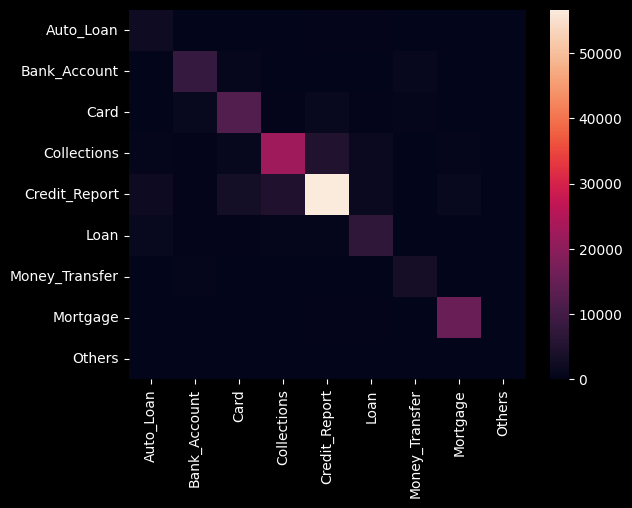

In [153]:
sns.heatmap(conf_mat)
plt.show()

##### Exporting the model

In [154]:
import pickle

In [155]:
with open("../output/count_vect.pkl", "wb") as f:
    pickle.dump(vect, f)
with open("../output/nb.pkl", "wb") as f:
    pickle.dump(nb_model, f)

##### Lets perform some tests to see if the model predicts some classes correctly

In [164]:
complaints_data["Complaints"][1545]

'I have a debt of Bank of America which was written off by the bank XX/XX/XXXX without my knowledge. I went to the bank XXXX XXXX since a law group kept on delving on XXXX XXXX Clerk File and garnishing salary from my work.This case has been closed.I paid a lesser amount to the bank to close this debt XXXX I sent them checks. I will greatly appreciate if this case will be resolve.'

In [165]:
complaints_data["Product"][1545]

'Collections'

In [166]:
complaints_data["Complaints"][5001]

'This is a personal Delta American Express charge card. I am a 30 year customer with American Express. I suddenly, without notice or warning have noted that " Charging Privileges Have Been Suspended \'\'. The card is current, with no money owed. This notice is only available online and I never received ANY written advice of this action. My account is not " paperless \'\'. At the phone number provided to call for information, after nearly an hour on the phone THREE TIMES, no explanation was ever provided and I was advised I " would be contacted \'\' to explain the ( lack of ) issue. I was never contacted. I had accumulated miles points on the card that I can not access and my charge privileges have been suspended. I am unable to obtain any information.'

In [167]:
complaints_data["Product"][5001]

'Card'

In [175]:
test_complaint_1 = complaints_data["Complaints"][1545]
test_complaint_2 = complaints_data["Complaints"][5001]

In [176]:
test_complaint = [test_complaint_1, test_complaint_2]

In [177]:
vect = pickle.load(open("../output/count_vect.pkl", "rb"))
nb_model = pickle.load(open("../output/nb.pkl", "rb"))

In [178]:
test_complaint = pd.Series(test_complaint)

In [179]:
test_complaint

0    I have a debt of Bank of America which was written off by the bank XX/XX/XXXX without my knowled...
1    This is a personal Delta American Express charge card. I am a 30 year customer with American Exp...
dtype: object

In [180]:
test_complaint = test_complaint.str.lower()

test_complaint = test_complaint.map(word_tokenize)

test_complaint = test_complaint.apply(remove_stop_words)

test_complaint = test_complaint.apply(lambda x: [" ".join(tokenizer.tokenize(t)) for t in x if len(tokenizer.tokenize(t))>0 ])

test_complaint = test_complaint.apply(lambda x: [(re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip()) for t in x if len((re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip())) > 0])

test_complaint = test_complaint.apply(lambda words: [stemmer.stem(word) for word in words])

In [181]:
test_complaint

0    [debt, bank, america, written, bank, without, knowledg, went, bank, sinc, law, group, kept, delv...
1    [person, delta, american, express, charg, card, 30, year, custom, american, express, suddenli, w...
dtype: object

In [184]:
test_complaint = test_complaint.apply(lambda x: " ".join(x))

In [185]:
test_complaint

0    debt bank america written bank without knowledg went bank sinc law group kept delv clerk file ga...
1    person delta american express charg card 30 year custom american express suddenli without notic ...
dtype: object

In [186]:
X_test = vect.transform(test_complaint)

In [205]:
nb_model.predict(X_test)

array(['Collections', 'Card'], dtype='<U14')

In [204]:
pd.DataFrame(nb_model.predict_proba(X_test).round(3), columns=nb_model.classes_)

,Auto_Loan,Bank_Account,Card,Collections,Credit_Report,Loan,Money_Transfer,Mortgage,Others
0,0.0,0.083,0.001,0.914,0.0,0.001,0.0,0.001,0.0
1,0.0,0.000,1.000,0.000,0.0,0.000,0.0,0.000,0.0


##### The predictiosn look okay.
##### Lets perform some tests to see if the model predicts some classes correctly for imbalanced classes

In [211]:
test_complaint_1 = complaints_data["Complaints"][1]
test_complaint_2 = complaints_data["Complaints"][2324447]
test_complaint = [test_complaint_1, test_complaint_2]
test_complaint = pd.Series(test_complaint)

test_complaint = test_complaint.str.lower()

test_complaint = test_complaint.map(word_tokenize)

test_complaint = test_complaint.apply(remove_stop_words)

test_complaint = test_complaint.apply(lambda x: [" ".join(tokenizer.tokenize(t)) for t in x if len(tokenizer.tokenize(t))>0 ])

test_complaint = test_complaint.apply(lambda x: [(re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip()) for t in x if len((re.sub(r'\b(?:xx{1,3}|xxxxxx|00{1,3})\b',"",t).strip())) > 0])

test_complaint = test_complaint.apply(lambda words: [stemmer.stem(word) for word in words])
test_complaint = test_complaint.apply(lambda x: " ".join(x))

X_test = vect.transform(test_complaint)
nb_model.predict(X_test)

pd.DataFrame(nb_model.predict_proba(X_test).round(3), columns=nb_model.classes_)

,Auto_Loan,Bank_Account,Card,Collections,Credit_Report,Loan,Money_Transfer,Mortgage,Others
0,0.89,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.0
1,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0


##### These seem to have been predicted correctly as well.